In [1]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd
import torch
import random
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import torch.optim as optim
from pprint import pprint
from tqdm import tqdm

from MatrixVectorizer import MatrixVectorizer
from preprocessing import antivectorize_df
from model import GSRNet, Discriminator
from train import train_gan, test_gan
from utils import track_memory, compute_degree_matrix_normalization_batch_numpy, get_parser, evaluate, plot_metrics_fold, LR_size, HR_size

### Reproducibility code
 - Our code is adjusted to run on gpu

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

CUDA is available. Using GPU.
cuda


# Import Data
 - The following code is used on the first run to read the dataset and antivectorize it in a form where it can be loaded for further runs. For first time run uncomment the following code 

In [3]:
# A_LR_train = pd.read_csv("../data/lr_train.csv")
# A_HR_train = pd.read_csv("../data/hr_train.csv")
# A_LR_test = pd.read_csv("../data/lr_test.csv")

# np.save('A_LR_train_matrix.npy', antivectorize_df(A_LR_train, LR_size))
# np.save('A_HR_train_matrix.npy', antivectorize_df(A_HR_train, HR_size))
# np.save('A_LR_test_matrix.npy', antivectorize_df(A_LR_test, LR_size))

In [4]:
A_LR_train_matrix = np.load('A_LR_train_matrix.npy')
A_HR_train_matrix = np.load('A_HR_train_matrix.npy')
A_LR_test_matrix = np.load("A_LR_test_matrix.npy")

print(A_LR_train_matrix.shape)
print(A_HR_train_matrix.shape)
print(A_LR_test_matrix.shape)

(167, 160, 160)
(167, 268, 268)
(112, 160, 160)


# Parameters
 - The optimal parameters based on our carried out experiments.

In [5]:
parser = get_parser()
# Create an empty Namespace to hold the default arguments
args = parser.parse_args([])
pprint(args.__dict__)

{'dropout_rate': 0.2,
 'early_stop_patient': 5,
 'embedding_size': 32,
 'epochs': 200,
 'hidden_dim': 268,
 'hr_dim': 268,
 'ks': [0.9, 0.7, 0.6, 0.5],
 'lmbda': 12,
 'lr': 0.001,
 'lr_dim': 160,
 'mean_dense': 0.0,
 'mean_gaussian': 0.0,
 'padding': 26,
 'splits': 3,
 'std_dense': 0.01,
 'std_gaussian': 0.1}


In [6]:
# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
X = A_LR_train_matrix  # np.random.normal(0, 0.5, (167, 160, 160))
Y = A_HR_train_matrix  # np.random.normal(0, 0.5, (167, 288, 288))
print(X.shape)
print(Y.shape)

(167, 160, 160)
(167, 268, 268)


In [7]:
X = compute_degree_matrix_normalization_batch_numpy(X)
A_LR_test_matrix = compute_degree_matrix_normalization_batch_numpy(A_LR_test_matrix)
print(X.shape)

(167, 160, 160)


# K-Fold Cross Validation
 - This is the cross-validation loop. We use KFold cross-validation to split 
the data into training and validation sets.

In [ ]:
cv = KFold(n_splits=args.splits, random_state=random_seed, shuffle=True)

best_model_fold_list = []
data_fold_list = []
i = 1

print(f"Starting Cross Validation.")
track_memory()
for train_index, test_index in cv.split(X):

    print(f"----- Fold {i} -----")
    track_memory()

    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = (
        X[train_index],
        X[test_index],
        Y[train_index],
        Y[test_index],
    )
    data_fold_list.append(
        (subjects_adj, test_adj, subjects_ground_truth, test_ground_truth)
    )

    netG = GSRNet(args).to(device)
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

    netD = Discriminator(args).to(device)
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

    # track_memory()
    # GAN model
    return_model = train_gan(
        netG,
        optimizerG,
        netD,
        optimizerD,
        subjects_adj,
        subjects_ground_truth,
        args,
        test_adj=test_adj,
        test_ground_truth=test_ground_truth,
    )

    test_mae = test_gan(return_model, test_adj, test_ground_truth, args)
    train_mae = test_gan(return_model, subjects_adj, subjects_ground_truth, args)
    print(f"Train MAE: {train_mae:.6f}, Val MAE: {test_mae:.6f}")
    best_model_fold_list.append(return_model)

    track_memory()

    i += 1

Starting Cross Validation.
Current memory usage: 1557.11 MB
----- Fold 1 -----
Current memory usage: 1557.11 MB


Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]

In [ ]:
CAL_GRAPH = False

res_list = []

for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()
    pred_matrices = np.zeros(gt_matrices.shape)
    with torch.no_grad():
        for j, test_adj in enumerate(test_adjs):
            pred = model(torch.from_numpy(test_adj))[0]
            pred = torch.clamp(pred, min=0.0, max=1.0)
            pred = pred.cpu()
            pred_matrices[j] = pred
    res_list.append(evaluate(pred_matrices, gt_matrices, cal_graph=CAL_GRAPH))

pd.DataFrame(res_list)

100%|██████████| 56/56 [00:00<00:00, 84.72it/s]


MAE:  0.12905551602870827
PCC:  0.6640298737001041
Jensen-Shannon Distance:  0.2777779162934726


100%|██████████| 56/56 [00:00<00:00, 86.88it/s]


MAE:  0.13759460449658764
PCC:  0.6362997007225183
Jensen-Shannon Distance:  0.28898757943952924


100%|██████████| 55/55 [00:00<00:00, 87.48it/s]


MAE:  0.13437376701058662
PCC:  0.6463051383952866
Jensen-Shannon Distance:  0.2830159134762792


,MAE,PCC,JSD
0,0.129056,0.664030,0.277778
1,0.137595,0.636300,0.288988
2,0.134374,0.646305,0.283016


/homes/cb1223/dl/graph_super_resolution/super_agsr_net/utils.py:358: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


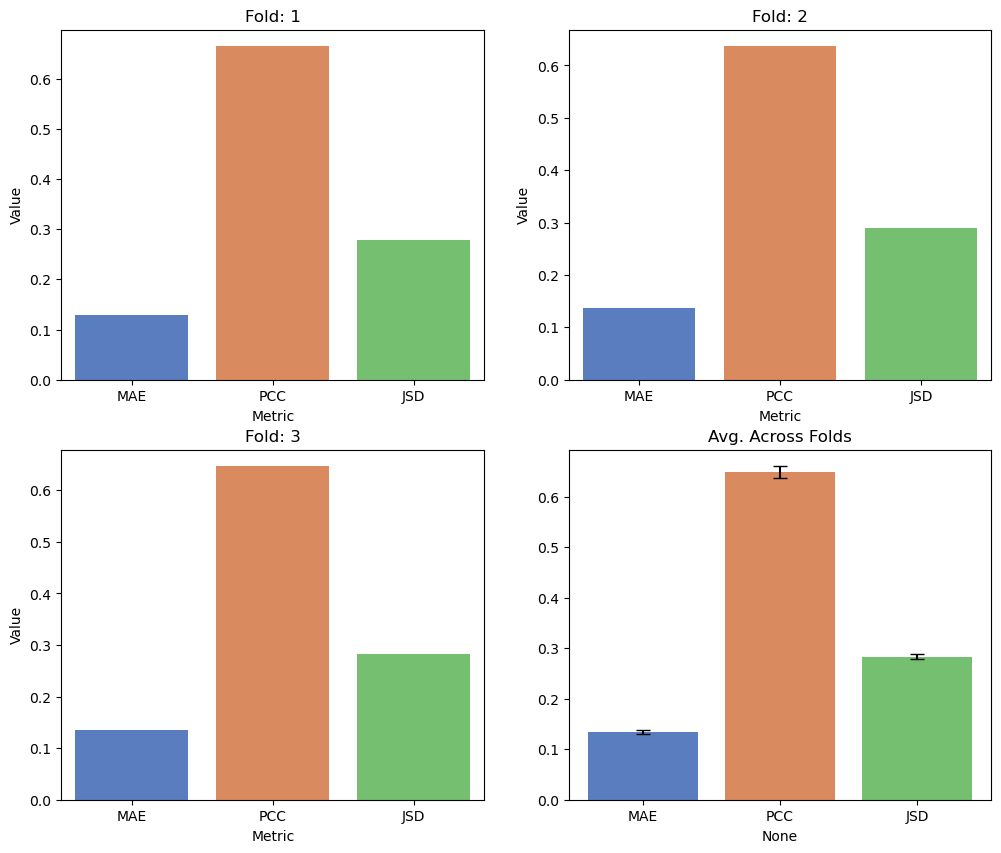

In [ ]:
plot_metrics_fold(res_list)

<!-- ![Alt text](../imgs/3-fold_result.png) -->

![Alt text](../imgs/bar_plot.png)

*Discussion:* This is the final scores of our 3-Fold cross validation based on the MAE, PCC and JSD metrics. The first plot is generated by setting the CAL_GRAPH Flag to false. On our complete final plot we can see that Mean Absolute Error (MAE) ranges from 0.1281 to 0.1378. The model predicts HR samples with a level of accuracy, but there is still room for improvement. Pearson Correlation Coefficients (PCC) are consistently above 0.63, indicating a moderately strong positive correlation between the predicted HR value and the ground truth. This shows that the model successfully captures the general trend of the data. Jensen-Shannon Distance (JSD) remains around 0.28, showing that the predicted HR value partially diverged from the ground truth. Lastly, the average MAE with 3 different centrality types is very low, signifying that the model’s prediction captures ground truth’s network structure very well.


In [ ]:
for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()

    output_pred_list = []
    with torch.no_grad():
        for test_adj in tqdm(test_adjs):
            output_pred = model(torch.from_numpy(test_adj))[0].cpu()
            output_pred = torch.clamp(output_pred, min=0.0, max=1.0)
            output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
            output_pred_list.append(output_pred)

    output_pred_stack = np.stack(output_pred_list, axis=0)
    output_pred_1d = output_pred_stack.flatten()

    df = pd.DataFrame(
        {
            "ID": [i + 1 for i in range(len(output_pred_1d))],
            "Predicted": output_pred_1d.tolist(),
        }
    )

    df.to_csv("predictions_fold_" + str(i + 1) + ".csv", index=False)

100%|██████████| 55/55 [00:12<00:00,  4.39it/s]


# Final Model
 - Below is the final train split performed on the parameter combination that performed the best on our KFold cross validation experiment.

In [ ]:
A_HR_train = pd.read_csv("../data/hr_train.csv")

pca = PCA(n_components=0.99, whiten=False)
A_HR_train_pca = pca.fit_transform(A_HR_train)
print(f"HR Train PCA shape: {A_HR_train_pca.shape}")

gm = GaussianMixture(n_components=5, random_state=random_seed)
A_HR_train_label = gm.fit_predict(A_HR_train_pca)
unique, counts = np.unique(A_HR_train_label, return_counts=True)
print(np.asarray((unique, counts)).T)

X = np.load("A_LR_train_matrix.npy")
y = np.load("A_HR_train_matrix.npy")

X = compute_degree_matrix_normalization_batch_numpy(X)

n_sample = X.shape[0]
X_train, X_val, y_train, y_val = train_test_split(
    X.reshape(n_sample, -1),
    y.reshape(n_sample, -1),
    test_size=0.10,
    random_state=random_seed,
    stratify=A_HR_train_label,
)

X_train = X_train.reshape(-1, LR_size, LR_size)
X_val = X_val.reshape(-1, LR_size, LR_size)
y_train = y_train.reshape(-1, HR_size, HR_size)
y_val = y_val.reshape(-1, HR_size, HR_size)

print("Train size:", len(X_train))
print("Val size:", len(X_val))

netG = GSRNet(args).to(device)
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

netD = Discriminator(args).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

track_memory()
# GAN model
final_model = train_gan(
    netG,
    optimizerG,
    netD,
    optimizerD,
    X_train,
    y_train,
    args,
    test_adj=X_val,
    test_ground_truth=y_val,
)
track_memory()

HR Train PCA shape: (167, 161)
[[ 0 13]
 [ 1 41]
 [ 2 14]
 [ 3 48]
 [ 4 51]]
Train size: 150
Val size: 17
Current memory usage: 2433.26 MB


Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]

Val Error: 0.129026
Current memory usage: 2433.26 MB


In [ ]:
pprint(args.__dict__)

{'dropout_rate': 0.2,
 'early_stop_patient': 5,
 'embedding_size': 32,
 'epochs': 200,
 'hidden_dim': 268,
 'hr_dim': 268,
 'ks': [0.9, 0.7, 0.6, 0.5],
 'lmbda': 24,
 'lr': 0.00010436239086997339,
 'lr_dim': 160,
 'mean_dense': 0.0,
 'mean_gaussian': 0.0,
 'padding': 26,
 'splits': 3,
 'std_dense': 0.01,
 'std_gaussian': 0.1}


In [ ]:
final_model.eval()
pred_train_matrices = np.zeros(y_train.shape)
pred_val_matrices = np.zeros(y_val.shape)
with torch.no_grad():
    for j, test_adj in enumerate(X_train):
        pred = final_model(torch.from_numpy(test_adj))[0]
        pred = torch.clamp(pred, min=0.0, max=1.0)
        pred = pred.cpu()
        pred_train_matrices[j] = pred

    print("Train")
    evaluate(pred_train_matrices, y_train)

    for j, test_adj in enumerate(X_val):
        pred = final_model(torch.from_numpy(test_adj))[0]
        pred = torch.clamp(pred, min=0.0, max=1.0)
        pred = pred.cpu()
        pred_val_matrices[j] = pred

    print("Val")
    evaluate(pred_val_matrices, y_val)

  6%|▌         | 9/150 [00:00<00:01, 87.86it/s]

Train


  0%|          | 0/17 [00:00<?, ?it/s]

MAE:  0.12964642981163652
PCC:  0.672104570498902
Jensen-Shannon Distance:  0.2781689976036065
Val


100%|██████████| 17/17 [00:00<00:00, 87.44it/s]


MAE:  0.1290249255863382
PCC:  0.6756079655601531
Jensen-Shannon Distance:  0.26894005997751674


In [ ]:
output_pred_list = []
final_model.eval()
with torch.no_grad():
    for i in tqdm(range(A_LR_test_matrix.shape[0])):
        output_pred = final_model(torch.Tensor(A_LR_test_matrix[i]))[0]
        output_pred = torch.clamp(output_pred, min=0.0, max=1.0)
        output_pred = output_pred.cpu()
        output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
        output_pred_list.append(output_pred)

100%|██████████| 112/112 [00:25<00:00,  4.36it/s]


In [ ]:
output_pred_stack = np.stack(output_pred_list, axis=0)
output_pred_1d = output_pred_stack.flatten()
assert output_pred_1d.shape == (4007136,)

In [ ]:
df = pd.DataFrame(
    {
        "ID": [i + 1 for i in range(len(output_pred_1d))],
        "Predicted": output_pred_1d.tolist(),
    }
)

df

,ID,Predicted
0,1,0.598163
1,2,0.620485
2,3,0.742166
3,4,0.667024
4,5,0.674739
...,...,...
4007131,4007132,0.000000
4007132,4007133,0.014872
4007133,4007134,0.284825
4007134,4007135,0.394527


*Note:* These are the predicted outputs of our best model that were submitted to the Kaggle competition.

In [ ]:
df.to_csv("final_model.csv", index=False)